# **Fit GLM to dmdm data**
---
We first fit normal GLM to the dataset.

## **HPC setting**
Ashwood's original script is written in python scirpts. Here, we rewrite it in Jupyter to make it more user-friendly to run on HPC with `dask`. [This](https://github.com/pierreglaser/hpc-tutorial/tree/main) is very useful resource to get familiar with `dask`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# allocate the computing resources
from dask_jobqueue import SLURMCluster
from distributed import Client
from joblib import Memory, Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits

cluster = SLURMCluster(
    workers=0,      # create the workers "lazily" (upon cluster.scal)
    memory='32g',   # amount of RAM per worker
    processes=1,    # number of execution units per worker (threads and processes)
    cores=1,        # among those execution units, number of processes
    # A lazy trick to avoid matplotlib crash with parallel plotting
    worker_extra_args=["--resources GPU=2"], # the only way to add GPUs
    local_directory='/nfs/nhome/live/skuroda/jobs', # set your path to save log
    log_directory='/nfs/nhome/live/skuroda/jobs' # set your path to save log
)   

memory = Memory('/nfs/nhome/live/skuroda/joblib-cache') # set your path

cluster.scale(10)
client = Client(cluster)
print(client.dashboard_link)

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/

http://192.168.234.11:38537/status


## **GLM fitting**
---

In [3]:
# ------- load modules -------
import autograd.numpy as np
import autograd.numpy.random as npr

from glm_utils import fit_glm, fit_glm_runml, fit_RT_glm, \
                      plot_input_vectors, plot_logOR_hit_vs_miss, plot_logOR_FA_vs_abort, \
                      plot_rt_weights
import sys
sys.path.insert(0, '../') # a lazy trick to search parent dir
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
from data_io import get_file_dir, load_session_fold_lookup, load_data, load_animal_list

from functools import partial
from collections import OrderedDict

In [4]:
# ------- setup variables -------
dname = 'dataAllMice'
C = 4  # number of output types/categories. Hit/FA/Miss/Abort
nested_outcome = OrderedDict() # define nested structure for behavioral outcomes
nested_outcome["Baseline"] = [2, 3]
nested_outcome["Change"] = [0, 1]

N_initializations = 10
num_folds = 5
labels_for_plot_y = ['CSize', 'COnset', 
                   'PrevMiss?', 'PrevHit?', 'PrevFA?', 'PrevAbort?',
                   'bias']
labels_for_plot_rt = ['CSize', 'COnset', 
                      'PrevMiss?', 'PrevHit?', 'PrevFA?', 'PrevAbort?',
                      'PrevCOnset', 'PrevRT','bias']
npr.seed(65)  # set seed in case of randomization

## **Fit GLM to all animals**
---
You fit GLM on two dimentional behavioral outcomes: both `y` (outcomes) and `rt` (reaction times).

In [5]:
# ------- setup path and load data -------
data_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster_rt'
# Create directory for results:
results_dir = get_file_dir().parents[1] / "results" / "dmdm_global_fit_rt" / dname
results_dir.mkdir(parents=True, exist_ok=True)

animal_file = data_dir / 'all_animals_concat.npz'
inpt_y, inpt_rt, y, session, rt, stim_onset = load_data(animal_file)
session_fold_lookup_table = load_session_fold_lookup(
    data_dir / 'all_animals_concat_session_fold_lookup.npz')

In [6]:
def fit_GLM_y(inpt_y, y, session, session_fold_lookup_table, labels_for_plot, nested_outcome, fold):
    # Subset to relevant covariates for covar set of interest:
    y = y.astype('int')
    figure_directory = results_dir / "GLM" / ("fold_" + str(fold)) 
    figure_directory.mkdir(parents=True, exist_ok=True)

    # Subset to sessions of interest for fold
    sessions_to_keep = session_fold_lookup_table[np.where(
        session_fold_lookup_table[:, 1] != fold), 0]
    idx_this_fold = [
        str(sess) in sessions_to_keep and y[id, 0] != -1
        for id, sess in enumerate(session)
    ]
    this_inpt_y, this_y, this_session = inpt_y[idx_this_fold, :], y[
        idx_this_fold, :], session[idx_this_fold]
    assert len(
        np.unique(this_y)
    ) == 4, "choice vector should only include 4 possible values"
    train_size = this_inpt_y.shape[0]

    M = this_inpt_y.shape[1]
    loglikelihood_train_vector = []

    for iter in range(N_initializations):  # GLM fitting should be
        # independent of initialization, so fitting multiple
        # initializations is a good way to check that everything is
        # working correctly
        loglikelihood_train, recovered_weights = fit_glm_runml([this_inpt_y],
                                                         [this_y], 
                                                         M, 
                                                         C,
                                                         nested_outcome)
        # weights_for_plotting = append_zeros(recovered_weights)
        plot_input_vectors(recovered_weights,
                           figure_directory,
                           title="GLM fit; Final LL = " +
                           str(loglikelihood_train),
                           save_title='init' + str(iter),
                           labels_for_plot=labels_for_plot)
        plot_logOR_hit_vs_miss(recovered_weights,
                               figure_directory,
                               title="GLM fit; Final LL = " +
                               str(loglikelihood_train),
                               save_title='init' + str(iter),
                               labels_for_plot=labels_for_plot)
        plot_logOR_FA_vs_abort(recovered_weights,
                               figure_directory,
                               title="GLM fit; Final LL = " +
                               str(loglikelihood_train),
                               save_title='init' + str(iter),
                               labels_for_plot=labels_for_plot)
        loglikelihood_train_vector.append(loglikelihood_train)
        np.savez(
            figure_directory / ('variables_of_interest_iter_' + str(iter) + '.npz'), 
            loglikelihood_train, recovered_weights)
        

fit_GLM_y_eachfold = partial(fit_GLM_y, inpt_y, y, session, session_fold_lookup_table, labels_for_plot_y, nested_outcome)        
fit_GLM_y_eachfold_cached = memory.cache(fit_GLM_y_eachfold)

In [7]:
def fit_GLM_rt(inpt_rt, rt, stim_onset, session, session_fold_lookup_table, labels_for_plot, nested_outcome, fold):
    # Subset to relevant covariates for covar set of interest:
    figure_directory = results_dir / "GLM" / ("fold_" + str(fold)) 
    figure_directory.mkdir(parents=True, exist_ok=True)

    # Subset to sessions of interest for fold
    sessions_to_keep = session_fold_lookup_table[np.where(
        session_fold_lookup_table[:, 1] != fold), 0]
    idx_this_fold = [
        str(sess) in sessions_to_keep and y[id, 0] != -1
        for id, sess in enumerate(session)
    ]
    this_inpt_rt, this_rt, this_stim_onset, this_session = \
          inpt_rt[idx_this_fold, :], rt[idx_this_fold, :], stim_onset[idx_this_fold, :], session[idx_this_fold]
    train_size = this_inpt_rt.shape[0]

    M = this_inpt_rt.shape[1]
    loglikelihood_train_vector = []

    for iter in range(N_initializations):  # GLM fitting should be
        # independent of initialization, so fitting multiple
        # initializations is a good way to check that everything is
        # working correctly
        loglikelihood_train, recovered_weights = fit_glm_runml([this_inpt_rt],
                                                         [this_rt], 
                                                         [this_stim_onset],
                                                         M)
        # weights_for_plotting = append_zeros(recovered_weights)
        plot_rt_weights(recovered_weights,
                           figure_directory,
                           title="GLM fit; Final LL = " +
                           str(loglikelihood_train),
                           save_title='init' + str(iter),
                           labels_for_plot=labels_for_plot)

        loglikelihood_train_vector.append(loglikelihood_train)
        np.savez(
            figure_directory / ('variables_of_interest_RT_iter_' + str(iter) + '.npz'), 
            loglikelihood_train, recovered_weights)
        
fit_GLM_rt_eachfold = partial(fit_GLM_rt, inpt_rt, y, session, session_fold_lookup_table, labels_for_plot_rt, nested_outcome)        
fit_GLM_rt_eachfold_cached = memory.cache(fit_GLM_rt_eachfold)

In [8]:
fold = 0
iter = 0

In [9]:
figure_directory = results_dir / "GLM" / ("fold_" + str(fold)) 
figure_directory.mkdir(parents=True, exist_ok=True)

# Subset to sessions of interest for fold
sessions_to_keep = session_fold_lookup_table[np.where(
    session_fold_lookup_table[:, 1] != fold), 0]
idx_this_fold = [
    str(sess) in sessions_to_keep and y[id, 0] != -1
    for id, sess in enumerate(session)
]
this_inpt_rt, this_rt, this_stim_onset, this_session = \
        inpt_rt[idx_this_fold, :], rt[idx_this_fold, :], stim_onset[idx_this_fold, :], session[idx_this_fold]
train_size = this_inpt_rt.shape[0]

M = this_inpt_rt.shape[1]
loglikelihood_train_vector = []

In [17]:
loglikelihood_train, recovered_weights = fit_RT_glm([this_inpt_rt],
                                                    [this_rt], 
                                                    [this_stim_onset],
                                                    M)

[[-2.76101268  2.54470557 -3.45410814  0.80206138  4.60280996  4.15291541
  -1.08799475  0.70035327  4.17047347]]


In [11]:
%%time
with threadpool_limits(limits=1, user_api='blas'):
    with parallel_backend('dask', wait_for_workers_timeout=120):
        # Parallel(verbose=100)(delayed(fit_GLM_y_eachfold_cached)(fold) for fold in range(num_folds))
        Parallel(verbose=100)(delayed(fit_GLM_rt_eachfold_cached)(fold) for fold in range(num_folds))

[[[ 2.58973611e+01  4.90412523e-01  4.27980564e-01 -3.85201783e-01
   -5.87238225e-01 -1.63835288e-01 -2.69668834e+00]
  [ 2.68203226e+01  2.91048414e-02 -1.09130652e+00 -4.56095787e-01
   -2.83916704e-01 -3.50608674e-01 -1.92535413e+00]
  [-3.00450413e+01 -1.36417494e+00 -6.90900213e-01  6.28867024e-01
    1.20165341e+00  5.50156351e-01  1.22011053e+00]
  [-2.42470245e+01 -1.61491548e+00  1.56745874e-01  8.77720572e-01
    8.37712106e-01  2.41667597e+00  6.94977536e-01]]]


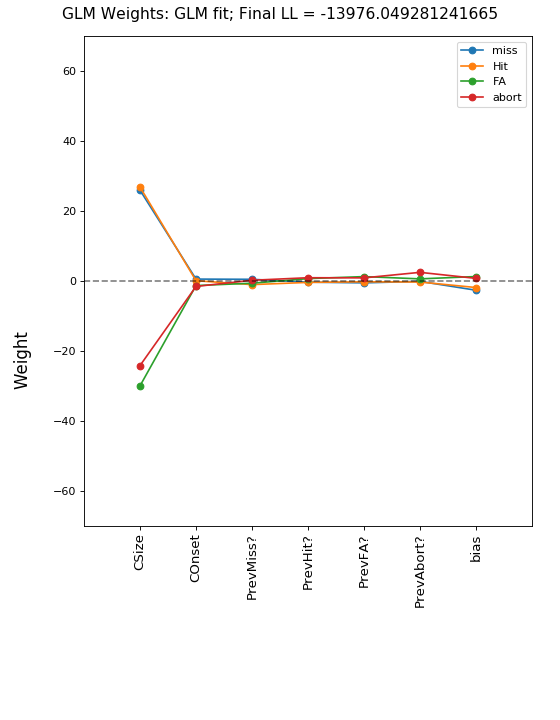

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gon

In [8]:
# Plot some results
from IPython.display import Image
example_npz_loc = str(results_dir / "GLM" / "fold_4" / 'variables_of_interest_iter_0.npz')
example_npz = np.load(example_npz_loc)
example_img_loc = str(results_dir / "GLM" / "fold_4" / 'glm_weights_init0.png')
print(example_npz['arr_1'])
Image(filename=example_img_loc) 

## **Fit GLM to each animal separately**
---

In [5]:
# ------- setup path and load data -------
data_2_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster' / "data_by_animal"
# Create directory for results:
results_2_dir = get_file_dir().parents[1] / "results" / "dmdm_individual_fit" / dname
results_2_dir.mkdir(parents=True, exist_ok=True)

animal_list = load_animal_list(data_2_dir / 'animal_list.npz')

In [6]:
def fit_GLM_separately(data_2_dir, results_2_dir, labels_for_plot, nested_outcome, num_folds, animal):
    # Fit GLM to data from single animal:
    animal_file = data_2_dir / (animal + '_processed.npz')
    session_fold_lookup_table = load_session_fold_lookup(
        data_2_dir / (animal + '_session_fold_lookup.npz'))
    this_results_dir = results_2_dir / animal

    # Load data
    print(str(animal_file))
    inpt, y, session, rt, stimT = load_data(animal_file)
    y = y.astype('int')


    for fold in range(num_folds):
        figure_directory = this_results_dir / "GLM" / ("fold_" + str(fold)) 
        figure_directory.mkdir(parents=True, exist_ok=True)

        # Subset to sessions of interest for fold
        sessions_to_keep = session_fold_lookup_table[np.where(
            session_fold_lookup_table[:, 1] != fold), 0]
        idx_this_fold = [
            str(sess) in sessions_to_keep and y[id, 0] != -1
            for id, sess in enumerate(session)
        ]
        this_inpt, this_y, this_session = inpt[idx_this_fold, :], \
                                            y[idx_this_fold, :], \
                                            session[idx_this_fold]
        assert len(
            np.unique(this_y)
        ) == 4, "choice vector should only include 4 possible values"
        train_size = this_inpt.shape[0]

        M = this_inpt.shape[1]
        loglikelihood_train_vector = []

        for iter in range(N_initializations):
            loglikelihood_train, recovered_weights = fit_glm([this_inpt],
                                                            [this_y], 
                                                            M, 
                                                            C,
                                                            nested_outcome)
            plot_input_vectors(recovered_weights,
                                figure_directory,
                                title="GLM fit; Final LL = " +
                                str(loglikelihood_train),
                                save_title='init' + str(iter),
                                labels_for_plot=labels_for_plot)
            loglikelihood_train_vector.append(loglikelihood_train)
            np.savez(
                figure_directory / ('variables_of_interest_iter_' + str(iter) + '.npz'),
                loglikelihood_train, recovered_weights)
            
fit_GLM_separately_eachanimal = partial(fit_GLM_separately, data_2_dir, results_2_dir, labels_for_plot, nested_outcome, num_folds)     
fit_GLM_separately_eachanimal_cached = memory.cache(fit_GLM_separately_eachanimal)


In [7]:
%%time
with threadpool_limits(limits=1, user_api='blas'):
    with parallel_backend('dask', wait_for_workers_timeout=60):
        Parallel(verbose=100)(delayed(fit_GLM_separately_eachanimal_cached)(animal) for animal in animal_list)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   6 | elapsed:   53.4s remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  1.8min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.8min remaining:   54.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min finished
CPU times: user 6.76 s, sys: 1.03 s, total: 7.79 s
Wall time: 1min 56s


In [8]:
# Plot some results
from IPython.display import Image
example_npz_loc = str(results_2_dir / 'x1119408' / "GLM" / "fold_4" / 'variables_of_interest_iter_9.npz')
example_npz = np.load(example_npz_loc)
example_img_loc = str(results_2_dir / "GLM" / "fold_4" / 'glm_weights_init9.png')
print(example_npz['arr_1'])
Image(filename=example_img_loc) 

array(['x1108393', 'x1116760', 'x1116765', 'x1117910', 'x1119408',
       'x1119541'], dtype='<U8')

In [ ]:
# Once finished, shut down the cluster and the client
cluster.close()
client.close()